In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical,plot_model

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

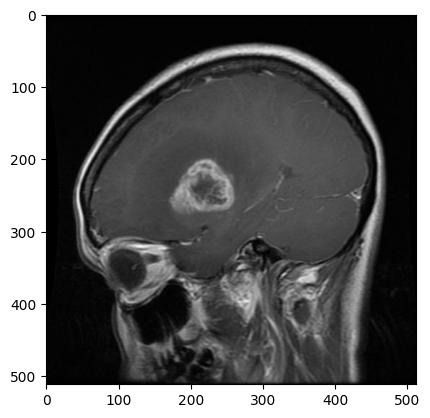

In [ ]:
img=mpimg.imread('/content/drive/MyDrive/DeepLearning/BrainMRI/Training/glioma_tumor/gg (106).jpg')
imgplot = plt.imshow(img)
plt.show()

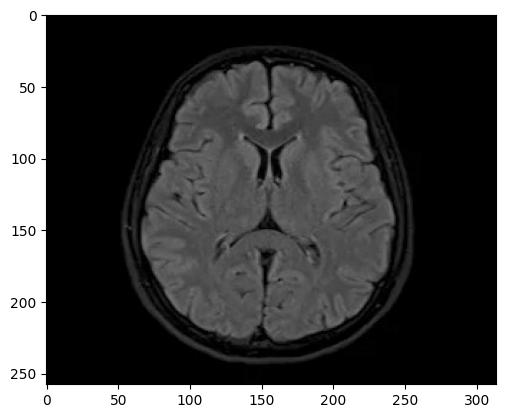

In [ ]:
img=mpimg.imread('/content/drive/MyDrive/DeepLearning/BrainMRI/Testing/no_tumor/image(100).jpg')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
from PIL import Image

In [ ]:
train_datasets = "/content/drive/MyDrive/DeepLearning/BrainMRI/Training"
validation_datasets = "/content/drive/MyDrive/DeepLearning/BrainMRI/Testing"

In [ ]:
batch_size = 32
image_size = 150

In [ ]:
def prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size):

    train_datagen = ImageDataGenerator(rescale=1./255,
                                                  shear_range = 0.2,
                                                  zoom_range = 0.2,
                                                  horizontal_flip = True,
                                                  vertical_flip= True,
                                                  width_shift_range=0.3,
                                                  fill_mode = "nearest")


    validation_datagen = ImageDataGenerator(rescale=1.0/255)


    train_generator = train_datagen.flow_from_directory(
        batch_size = batch_size,
        directory = train_datasets,
        shuffle = True,
        target_size = (image_size, image_size),
        class_mode = "categorical"
    )

    validation_generator = validation_datagen.flow_from_directory(
        batch_size = batch_size,
        directory = validation_datasets,
        shuffle = True,
        target_size = (image_size, image_size),
        class_mode = "categorical"
    )


    return train_generator, validation_generator

In [ ]:
train_data , validation_data = prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
densenet= tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    pooling=None,
    input_shape=(150,150,3)
)

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
for layer in densenet.layers:
    layer.trainable= False

In [ ]:
def addTopModel(bottom_model, num_class, D=64):
    top_model= bottom_model.output
    top_model= Flatten(name="flatten") (top_model)
    top_model= Dense(D, activation="relu") (top_model)
    top_model= Dropout(0.2) (top_model)
    top_model= Dense(num_class, activation="softmax") (top_model)
    return top_model

In [ ]:
num_classes= 4
Fc_Head = addTopModel(densenet, num_classes)
model = Model(inputs= densenet.input, outputs= Fc_Head)

In [ ]:
checkpoint= ModelCheckpoint("/Trained Models/densenet101.h5",
                            monitor= "val_loss",
                            mode= "min",
                            save_best_only= True,
                            verbose=1)

earlystop= EarlyStopping(monitor= "val_loss",
                         min_delta= 0,
                         patience= 10,
                         verbose=1,
                         restore_best_weights= True)


reduce_lr= ReduceLROnPlateau(monitor= "val_loss",
                         factor=0.1,
                         patience= 5,
                         verbose=1,
                         min_delta= 0.00001)


callbacks=[earlystop, checkpoint, reduce_lr]

In [ ]:
model.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(learning_rate=0.001),
              metrics= ['accuracy'])

In [ ]:
nb_train_samples= 2870
nb_validation_samples= 394
epochs= 20
batch_size= 32

history= model.fit(train_data,
                   steps_per_epoch= nb_train_samples//batch_size,
                   epochs= epochs,
                   callbacks=callbacks,
                   validation_data= validation_data,
                   validation_steps= nb_validation_samples//batch_size,
                    shuffle= True)

Epoch 1/20
10/89 [==>...........................] - ETA: 5:36 - loss: 5.9870 - accuracy: 0.3613

KeyboardInterrupt: 